In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.datasets import load_diabetes
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from IPython.display import Image
%matplotlib inline 
sns.set(style="ticks")

In [52]:
# df = pd.read_csv("Amazon Sale Report.csv")
df = load_diabetes(as_frame=True).get('data')

This dataset provides detailed insights into Amazon sales data, including SKU Code, Design Number, Stock, Category, Size and Color, to help optimize product profitability

- Category: Type of product. (String)
- Size: Size of the product. (String)
- Date: Date of the sale. (Date)
- Status: Status of the sale. (String)
- Fulfilment: Method of fulfilment. (String)
- Style: Style of the product. (String)
- SKU: Stock Keeping Unit. (String)
- ASIN: Amazon Standard Identification Number. (String)
- Courier Status: Status of the courier. (String)
- Qty: Quantity of the product. (Integer)
- Amount: Amount of the sale. (Float)
- B2B: Business to business sale. (Boolean)
- Currency: The currency used for the sale. (String)

In [53]:
df

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930


In [54]:
x_col_list = ['s1', 's2', 's3']

In [55]:
def diagnostic_plots(df, variable, title):
    fig, ax = plt.subplots(figsize=(10,7))
    # гистограмма
    plt.subplot(2, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(2, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    # ящик с усами
    plt.subplot(2, 2, 3)
    sns.violinplot(x=df[variable])    
    # ящик с усами
    plt.subplot(2, 2, 4)
    sns.boxplot(x=df[variable])  
    fig.suptitle(title)
    plt.show()

In [56]:
df.shape

(442, 10)

C:\Users\hae19\AppData\Local\Temp\ipykernel_13540\223523601.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


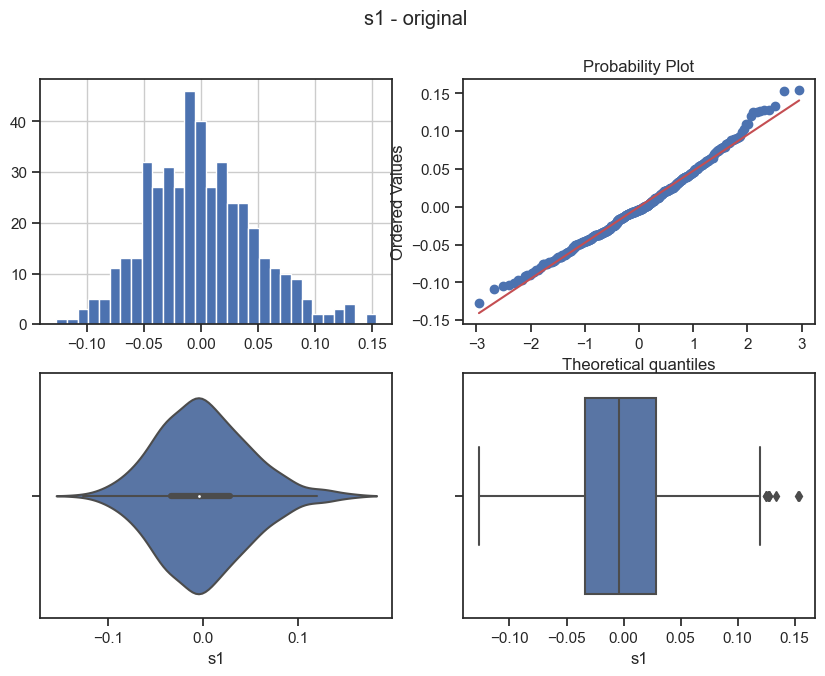

In [57]:
diagnostic_plots(df, 's1', 's1 - original')

C:\Users\hae19\AppData\Local\Temp\ipykernel_13540\223523601.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


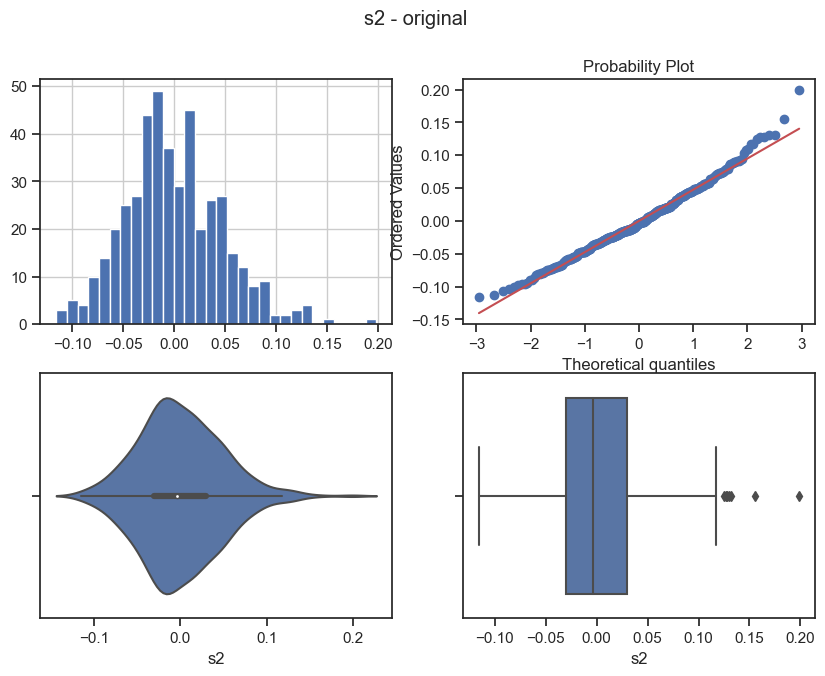

In [58]:
diagnostic_plots(df, 's2', 's2 - original')

In [59]:
# Тип вычисления верхней и нижней границы выбросов
from enum import Enum
class OutlierBoundaryType(Enum):
    SIGMA = 1
    QUANTILE = 2
    IRQ = 3

In [60]:
# Функция вычисления верхней и нижней границы выбросов
def get_outlier_boundaries(df, col, outlier_boundary_type: OutlierBoundaryType):
    if outlier_boundary_type == OutlierBoundaryType.SIGMA:
        K1 = 3
        lower_boundary = df[col].mean() - (K1 * df[col].std())
        upper_boundary = df[col].mean() + (K1 * df[col].std())

    elif outlier_boundary_type == OutlierBoundaryType.QUANTILE:
        lower_boundary = df[col].quantile(0.05)
        upper_boundary = df[col].quantile(0.95)

    elif outlier_boundary_type == OutlierBoundaryType.IRQ:
        K2 = 1.5
        IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
        lower_boundary = df[col].quantile(0.25) - (K2 * IQR)
        upper_boundary = df[col].quantile(0.75) + (K2 * IQR)

    else:
        raise NameError('Unknown Outlier Boundary Type')
        
    return lower_boundary, upper_boundary  

### Устранение выбросов

C:\Users\hae19\AppData\Local\Temp\ipykernel_13540\223523601.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


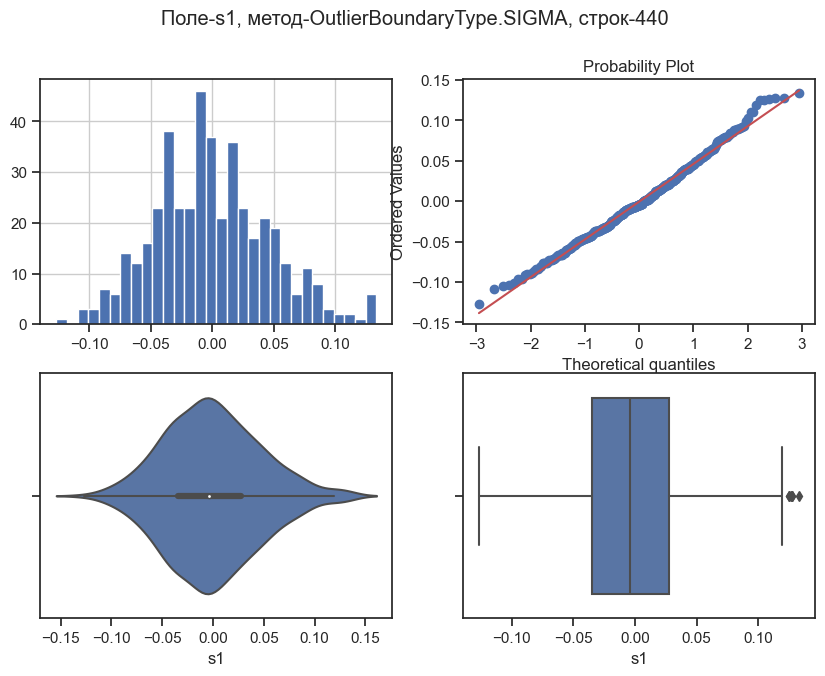

C:\Users\hae19\AppData\Local\Temp\ipykernel_13540\223523601.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


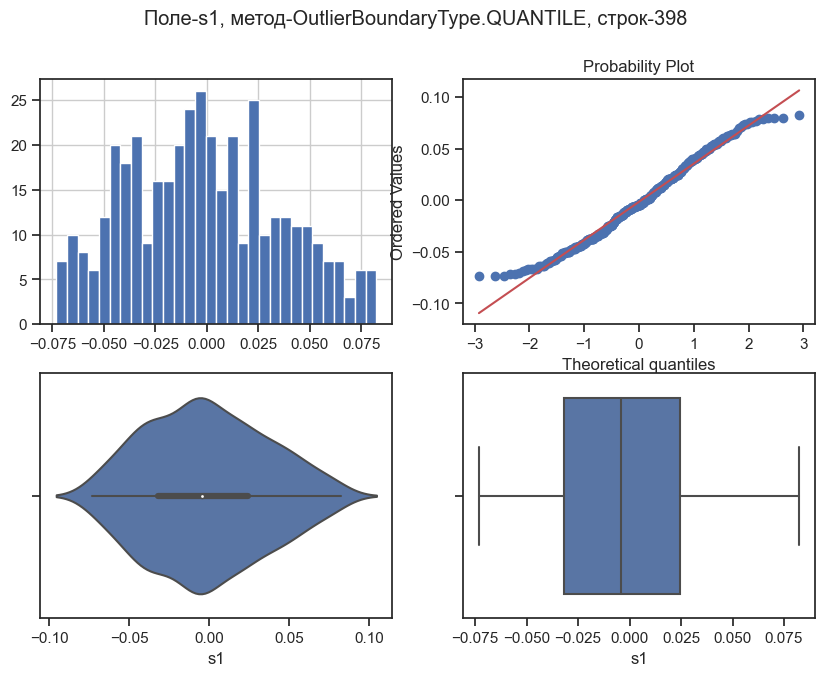

C:\Users\hae19\AppData\Local\Temp\ipykernel_13540\223523601.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


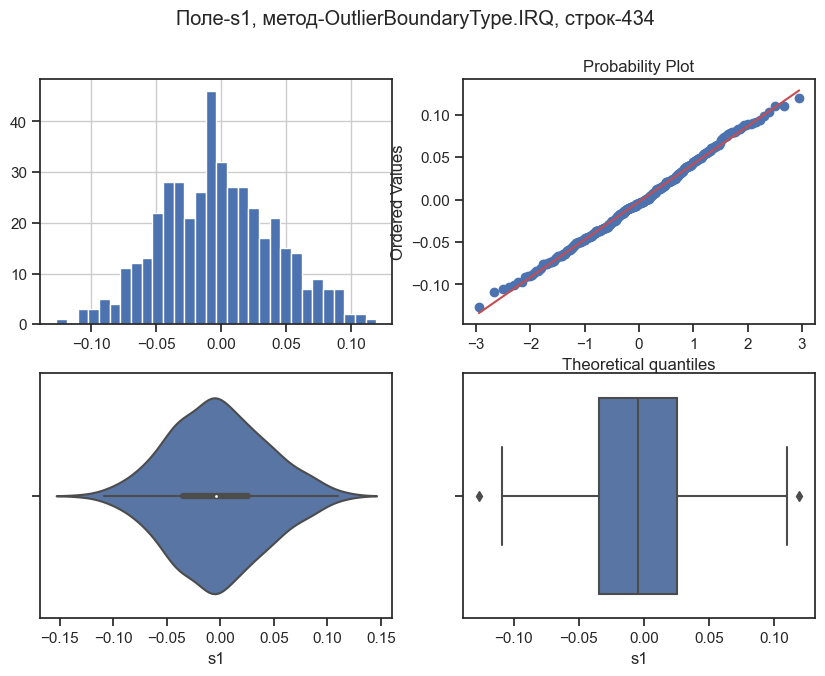

C:\Users\hae19\AppData\Local\Temp\ipykernel_13540\223523601.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


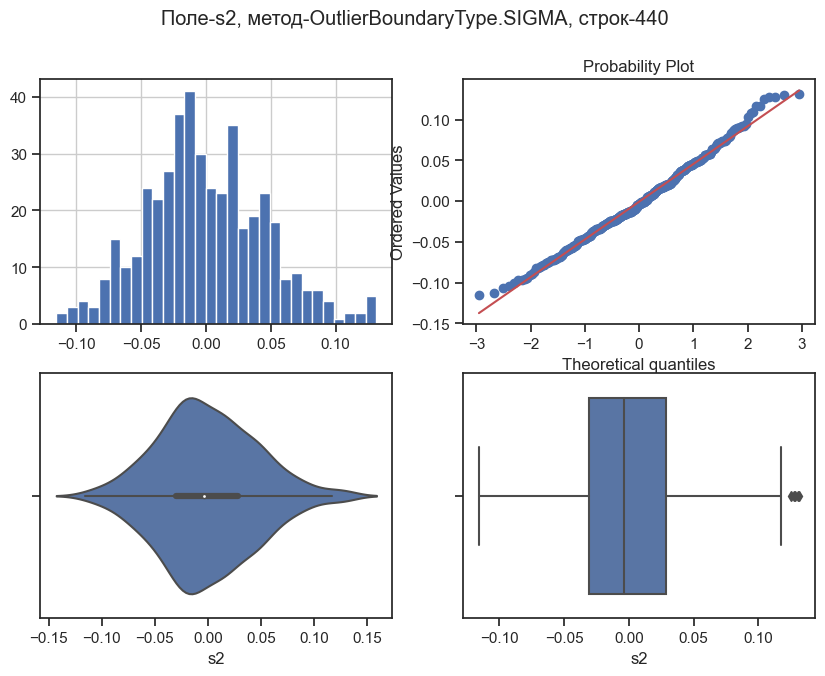

C:\Users\hae19\AppData\Local\Temp\ipykernel_13540\223523601.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


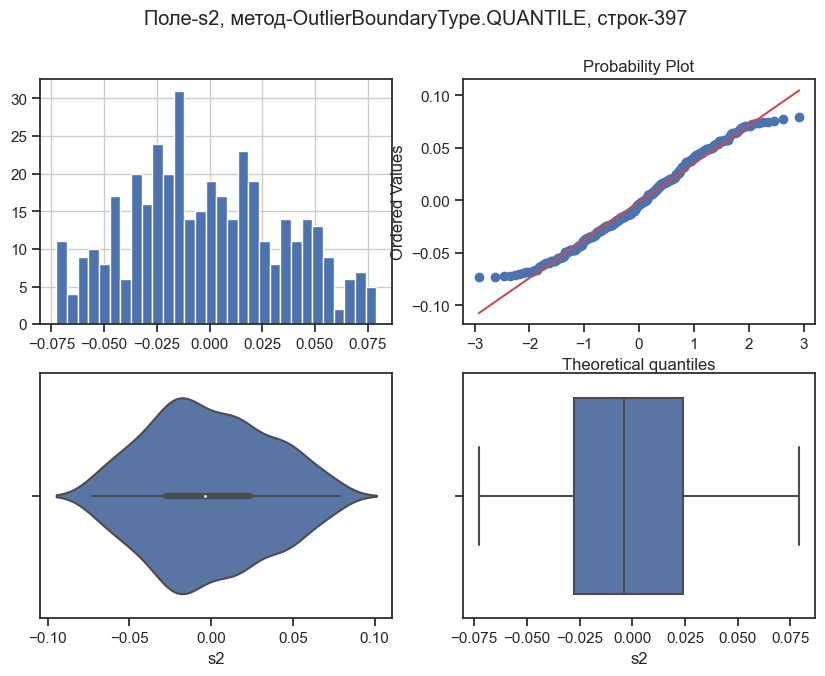

C:\Users\hae19\AppData\Local\Temp\ipykernel_13540\223523601.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


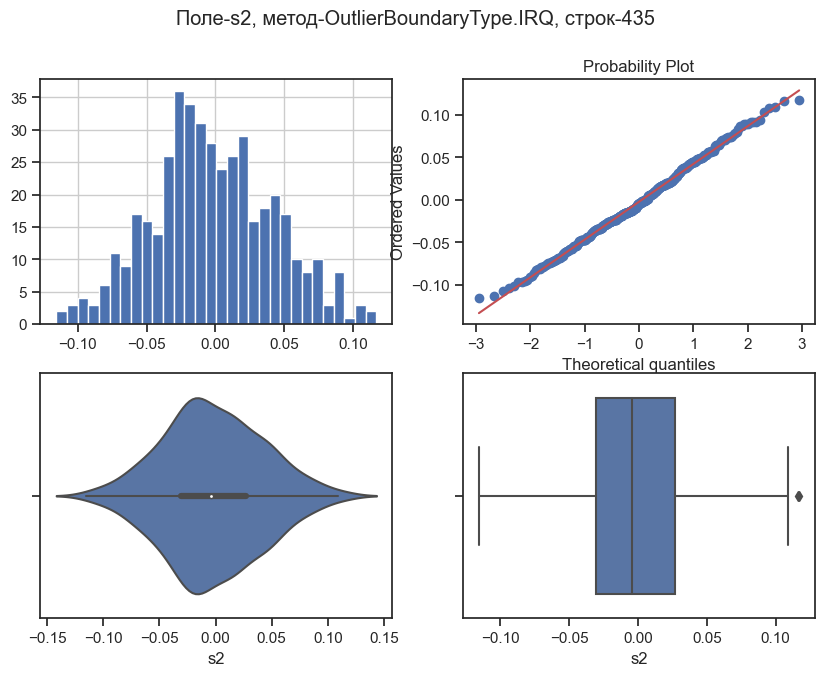

C:\Users\hae19\AppData\Local\Temp\ipykernel_13540\223523601.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


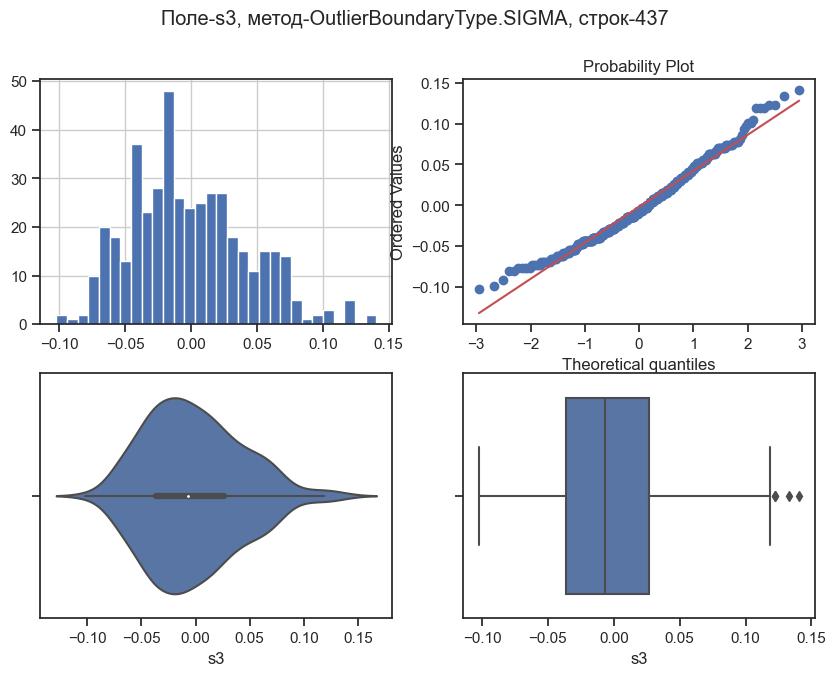

C:\Users\hae19\AppData\Local\Temp\ipykernel_13540\223523601.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


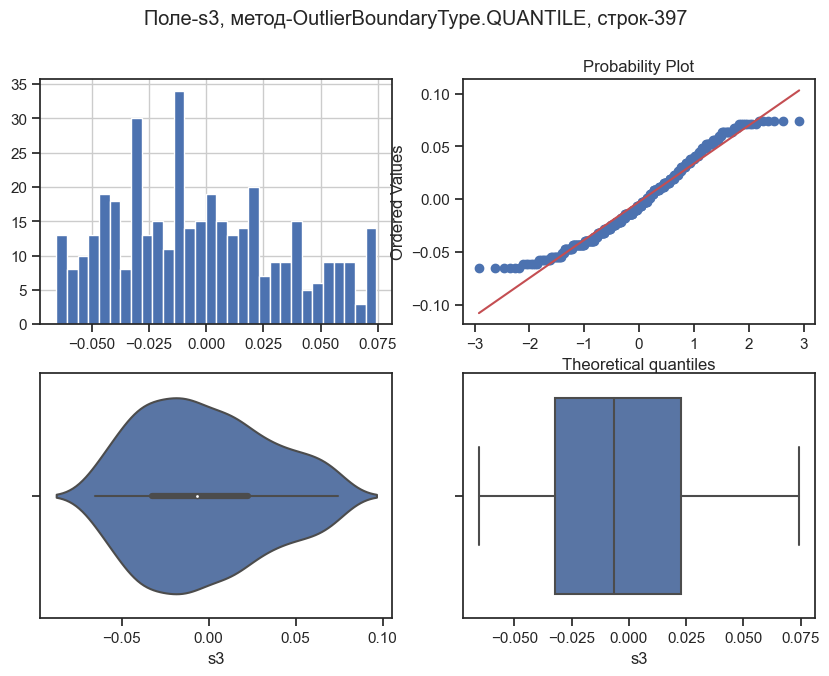

C:\Users\hae19\AppData\Local\Temp\ipykernel_13540\223523601.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


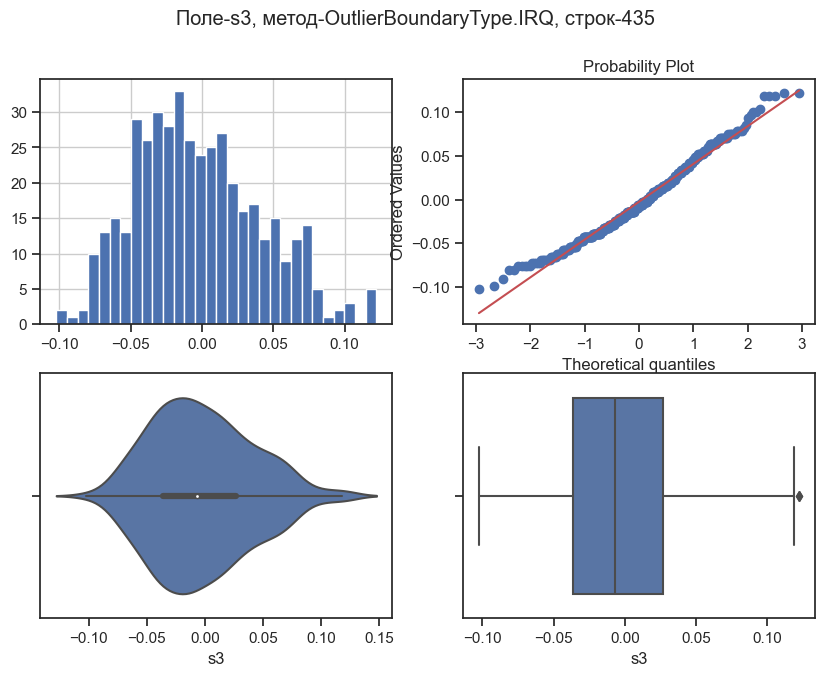

In [61]:
for col in x_col_list:    
    for obt in OutlierBoundaryType:
        # Вычисление верхней и нижней границы
        lower_boundary, upper_boundary = get_outlier_boundaries(df, col, obt)
        # Флаги для удаления выбросов
        outliers_temp = np.where(df[col] > upper_boundary, True, 
                                 np.where(df[col] < lower_boundary, True, False))
        # Удаление данных на основе флага
        data_trimmed = df.loc[~(outliers_temp), ]  
        title = 'Поле-{}, метод-{}, строк-{}'.format(col, obt, data_trimmed.shape[0])
        diagnostic_plots(data_trimmed, col, title)

C:\Users\hae19\AppData\Local\Temp\ipykernel_13540\223523601.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


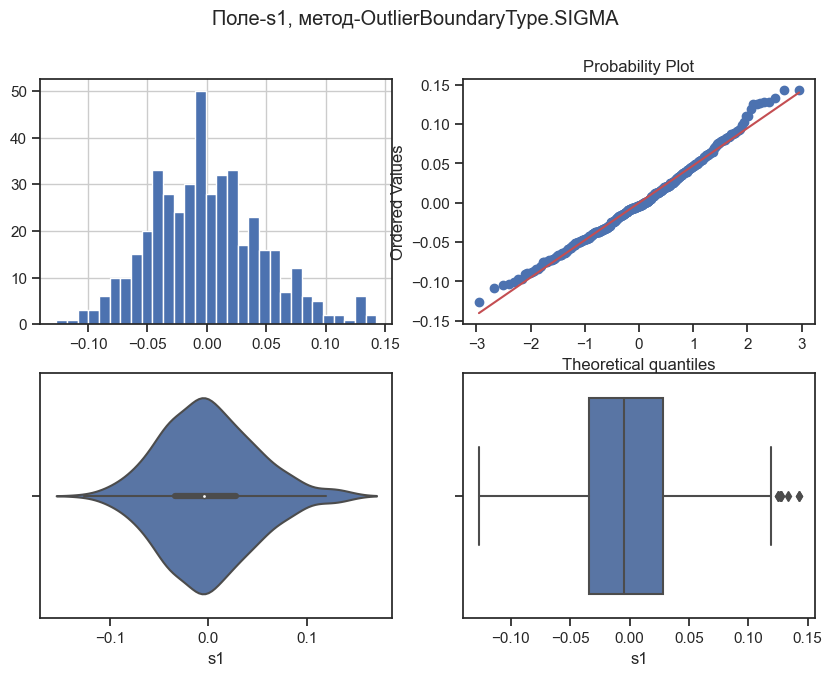

C:\Users\hae19\AppData\Local\Temp\ipykernel_13540\223523601.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


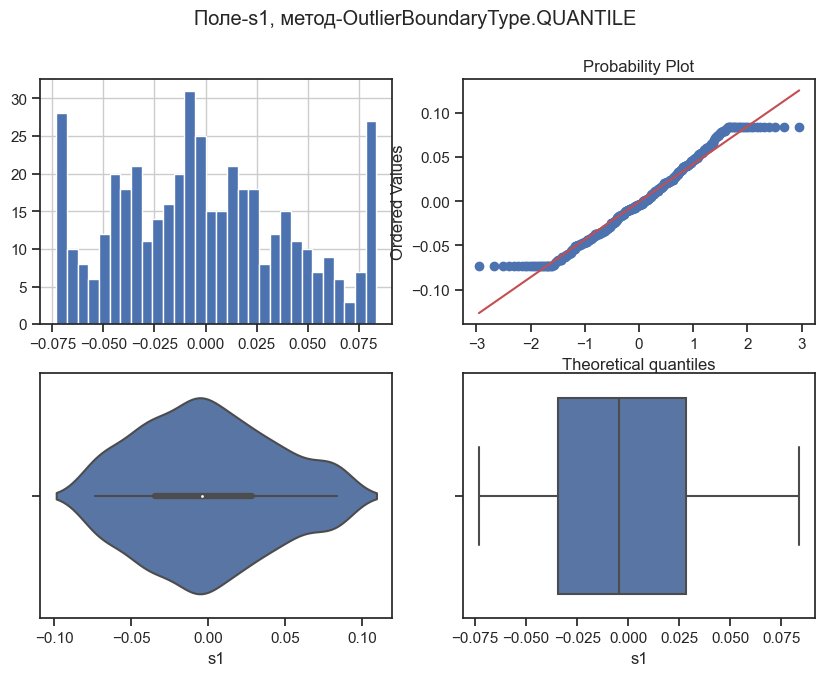

C:\Users\hae19\AppData\Local\Temp\ipykernel_13540\223523601.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


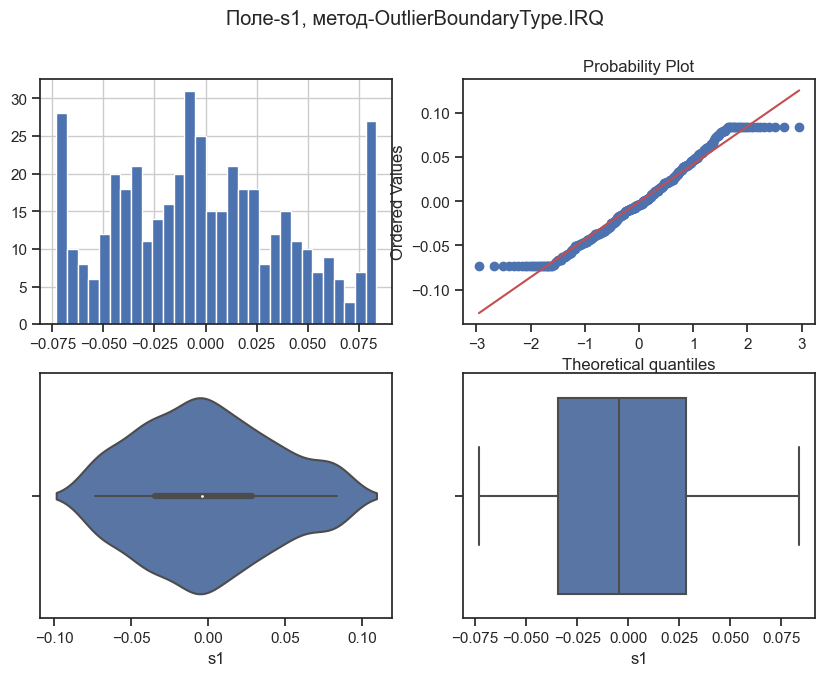

C:\Users\hae19\AppData\Local\Temp\ipykernel_13540\223523601.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


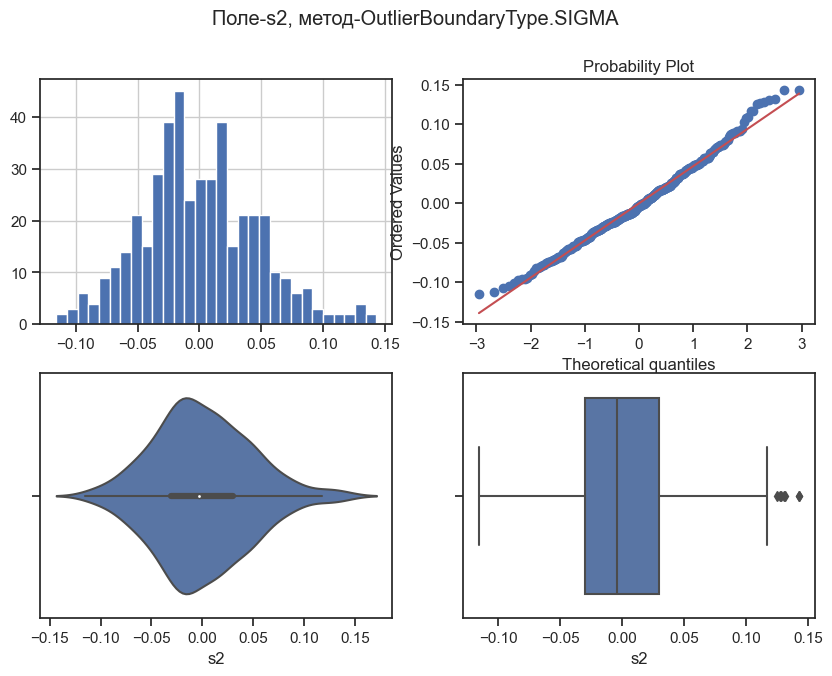

C:\Users\hae19\AppData\Local\Temp\ipykernel_13540\223523601.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


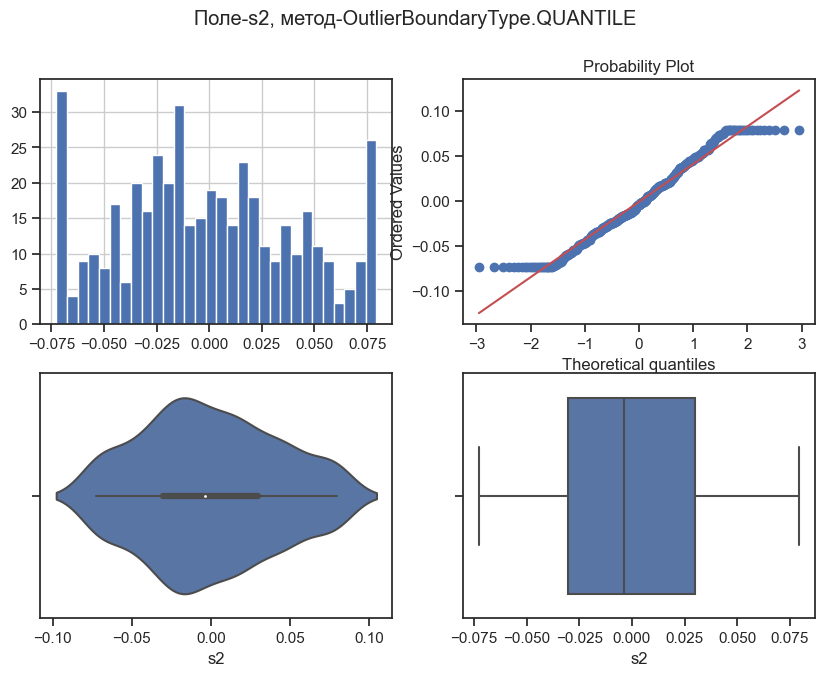

C:\Users\hae19\AppData\Local\Temp\ipykernel_13540\223523601.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


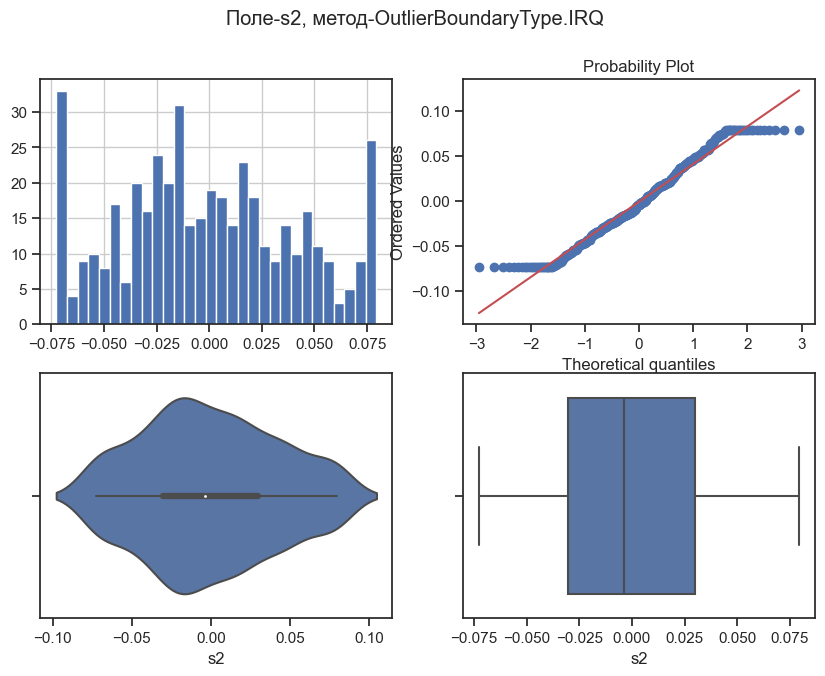

C:\Users\hae19\AppData\Local\Temp\ipykernel_13540\223523601.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


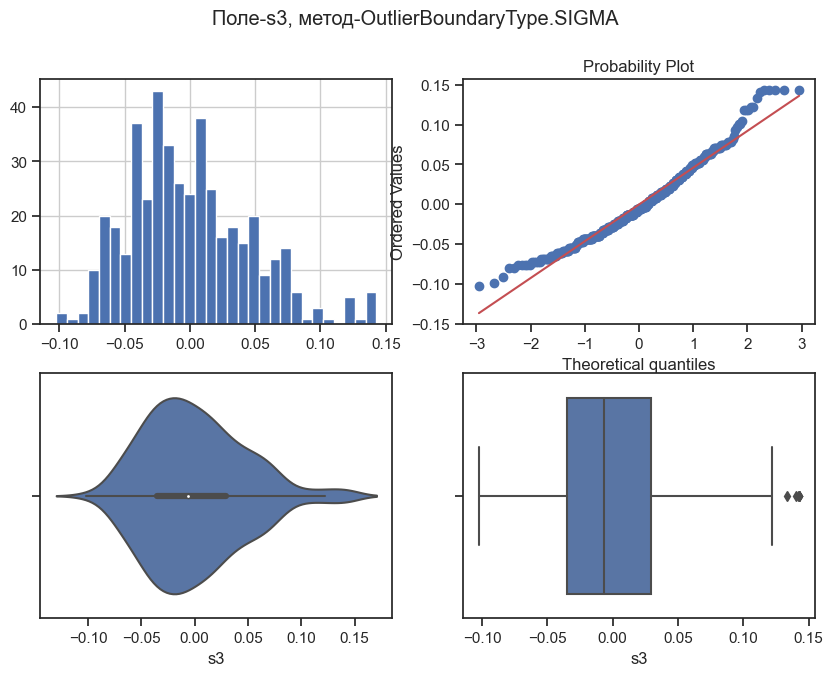

C:\Users\hae19\AppData\Local\Temp\ipykernel_13540\223523601.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


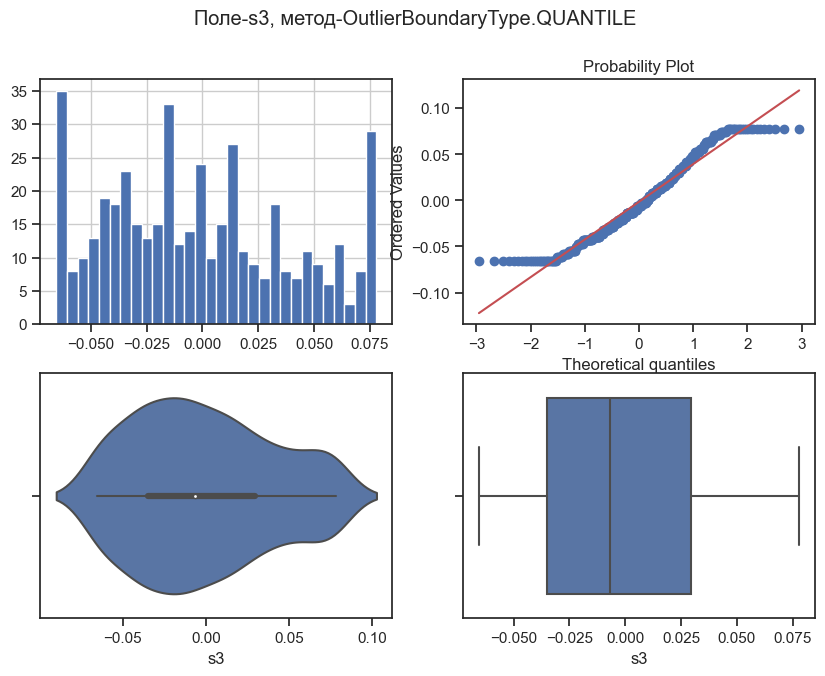

C:\Users\hae19\AppData\Local\Temp\ipykernel_13540\223523601.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


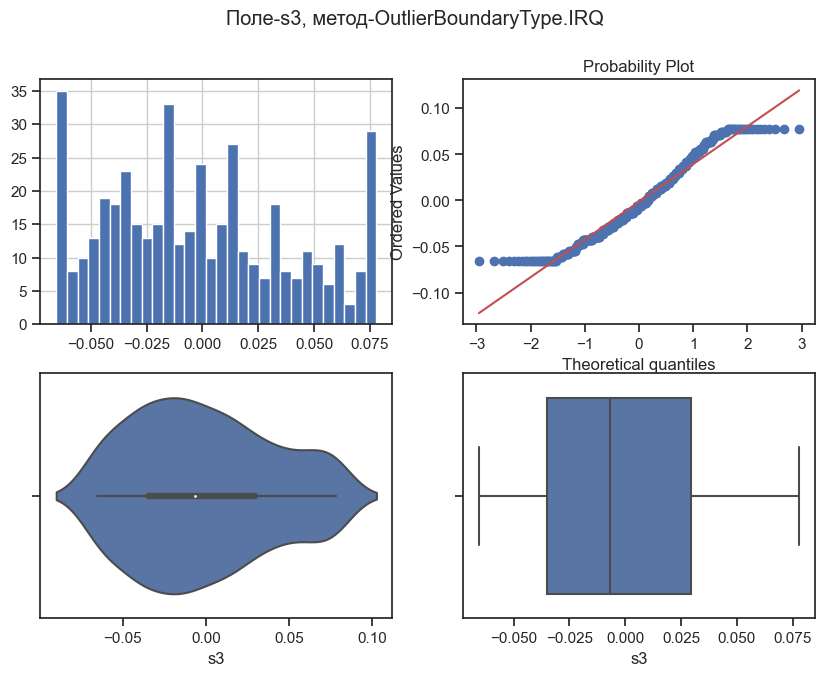

In [62]:
for col in x_col_list:    
    for obt in OutlierBoundaryType:
        # Вычисление верхней и нижней границы
        lower_boundary, upper_boundary = get_outlier_boundaries(df, col, obt)
        # Изменение данных
        df[col] = np.where(df[col] > upper_boundary, upper_boundary, 
                                 np.where(df[col] < lower_boundary, lower_boundary, df[col]))
        title = 'Поле-{}, метод-{}'.format(col, obt)
        diagnostic_plots(df, col, title)

In [77]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = pd.concat([self.df, pd.DataFrame.from_records(temp)])
        # self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()   

In [78]:
# DataFrame не содержащий целевой признак
X_ALL = df.drop('age', axis=1)

# Разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X_ALL, df['age'],
                                                    test_size=0.2,
                                                    random_state=1)
# Преобразуем массивы в DataFrame
X_train_df = pd.DataFrame(X_train, columns=X_ALL.columns)
X_test_df = pd.DataFrame(X_test, columns=X_ALL.columns)

X_train_df.shape, X_test_df.shape

((353, 9), (89, 9))

In [79]:
# Список методов обработки выбросов
method_list = ['Original']

# Список наборов данных
x_train_list = [X_train_df]
y_train_list = [y_train]

In [80]:
# Удаление выбросов
for obt in OutlierBoundaryType:

    df1 = X_train_df.copy()
    df1['age'] = y_train
    
    # Вычисление верхней и нижней границы
    s1_lower_boundary, s1_upper_boundary = get_outlier_boundaries(df1, 's1', obt)
    s2_lower_boundary, s2_upper_boundary = get_outlier_boundaries(df1, 's2', obt)
    s3_lower_boundary, s3_upper_boundary = get_outlier_boundaries(df1, 's3', obt)

    # Флаги для удаления выбросов  
    outliers_s1 = np.where(df1['s1'] > s1_upper_boundary, True, 
                             np.where(df1['s1'] < s1_lower_boundary, True, False))
    outliers_s2 = np.where(df1['s2'] > s2_upper_boundary, True, 
                             np.where(df1['s2'] < s2_lower_boundary, True, False))
    outliers_s3 = np.where(df1['s3'] > s3_upper_boundary, True, 
                             np.where(df1['s3'] < s3_lower_boundary, True, False))

    # Изменение данных
    data_train_trimmed = df1.loc[~(outliers_s1 + outliers_s2 + outliers_s3), ]
    x_data_train_trimmed = data_train_trimmed.drop('age', axis=1)
    y_data_train_trimmed = data_train_trimmed['age']
    title = '{}-trimmed'.format(obt)
    # Сохранение в списки
    method_list.append(title)
    x_train_list.append(x_data_train_trimmed)
    y_train_list.append(y_data_train_trimmed)

In [81]:
# Замена выбросов
for obt in OutlierBoundaryType:
    
    df2 = X_train_df.copy()
    
    for col in x_col_list:    
        # Вычисление верхней и нижней границы
        lower_boundary, upper_boundary = get_outlier_boundaries(df2, col, obt)
        # Изменение данных
        df2[col] = np.where(df2[col] > upper_boundary, upper_boundary, 
                                 np.where(df2[col] < lower_boundary, lower_boundary, df2[col]))

    title = '{}-updated'.format(obt)
    # Сохранение в списки
    method_list.append(title)
    x_train_list.append(df2)        
    y_train_list.append(y_train)

In [82]:
clas_models_dict = {
    'LinR': LinearRegression(), 
    'SVR': SVR(),
    'KNN_5':KNeighborsRegressor(n_neighbors=5),
    'Tree':DecisionTreeRegressor(random_state=1),
    'GB': GradientBoostingRegressor(random_state=1),
    'RF':RandomForestRegressor(n_estimators=50, random_state=1)
}

In [83]:
def test_models(clas_models_dict, method_list, x_train_list, y_train_list, X_test, y_test):
    logger = MetricLogger()
    for model_name, model in clas_models_dict.items():
        for name, (x_data, y_data) in zip(method_list, zip(x_train_list, y_train_list)):
            model.fit(x_data, y_data)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            logger.add(model_name, name, mse)
    return logger

In [84]:
%%time
logger = test_models(clas_models_dict, method_list, x_train_list, y_train_list, X_test, y_test)

CPU times: total: 1.12 s
Wall time: 1.14 s


In [85]:
# Построим графики метрик качества модели
for model in clas_models_dict:
    logger.plot('Модель: ' + model, model, figsize=(7, 6))

ValueError: Image size of 122445x529 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 700x600 with 1 Axes>

ValueError: Image size of 116843x529 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 700x600 with 1 Axes>

ValueError: Image size of 120124x529 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 700x600 with 1 Axes>

ValueError: Image size of 68616x529 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 700x600 with 1 Axes>

ValueError: Image size of 120925x529 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 700x600 with 1 Axes>

ValueError: Image size of 123516x529 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 700x600 with 1 Axes>